In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Excercise 10.13

In [2]:
coffee_data = pd.read_csv("coffee_ratings.csv")

In [3]:
coffee_data = coffee_data[["farm_name","total_cup_points",'aroma', 'aftertaste' ]]

In [4]:
coffee_data.head()

,farm_name,total_cup_points,aroma,aftertaste
0,metad plc,90.58,8.67,8.67
1,metad plc,89.92,8.75,8.50
2,"san marcos barrancas ""san cristobal cuch",89.75,8.42,8.42
3,yidnekachew dabessa coffee plantation,89.00,8.17,8.42
4,metad plc,88.83,8.25,8.25


Because these are not independant samples , for this exercise we just look at one sample per farm name

In [5]:
new_coffee= coffee_data.groupby('farm_name').sample().reset_index(drop=True)

## Exercise 10.14
Model new_coffee rating by its aroma

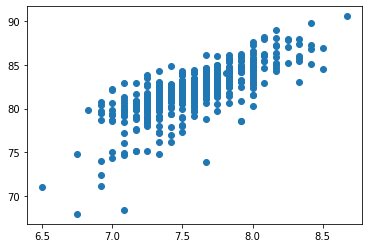

In [6]:
plt.scatter(new_coffee.aroma, new_coffee.total_cup_points)

Looks like a linear model would be *useful*

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, aroma, total_cup_points_sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 58 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,34.835,1.895,31.229,38.358,0.008,0.006,58544.0,30969.0,1.0
aroma,6.236,0.250,5.772,6.712,0.001,0.001,58645.0,31330.0,1.0
total_cup_points_sigma,1.882,0.056,1.777,1.985,0.000,0.000,58244.0,30070.0,1.0


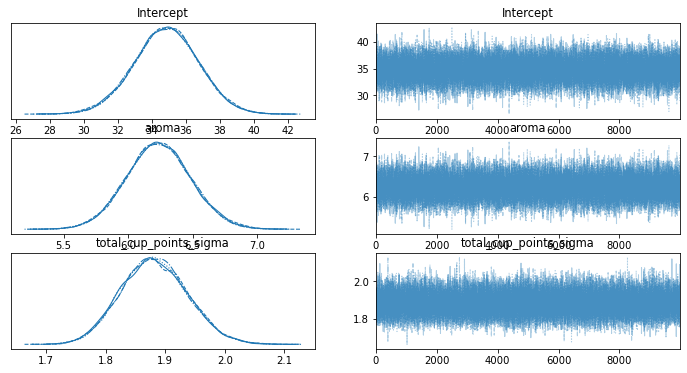

In [17]:
model = bmb.Model('total_cup_points ~ aroma', new_coffee)
results = model.fit(draws=10000, chains=4, cores=1)
az.plot_trace(results)
az.summary(results)

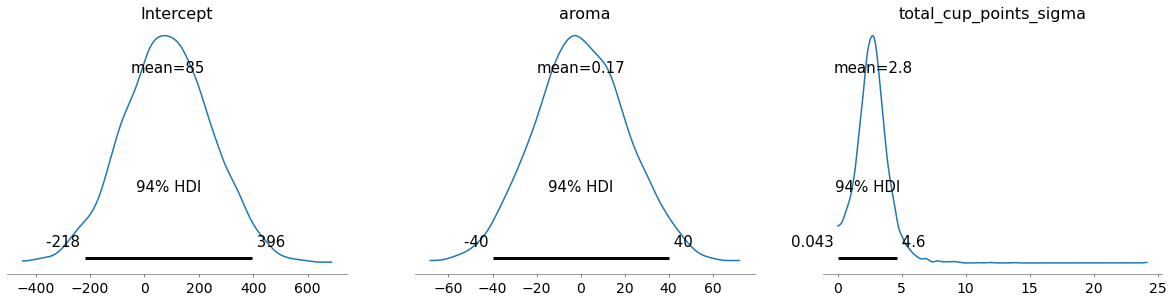

In [10]:
model.plot_priors();

* The priors seem weak informative, although maybe sigma could be a bit weaker? 
* There is strong evidence of a positive relationship between aroma and total_cup_points, for example none of the samples of the slope are less then 5!

In [24]:
np.sum(results.posterior.aroma.values.flatten() <5)

0

In [7]:
sigma_prior = bmb.Prior('Exponential', lam= 1/75.)
model2=  bmb.Model('total_cup_points ~ aroma', new_coffee, priors = {'sigma': sigma_prior})

In [8]:
model2.build()
model2

Formula: total_cup_points ~ aroma
Family name: Gaussian
Link: identity
Observations: 571
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 82.1628, sigma: 158.076)
    aroma ~ Normal(mu: 0.0, sigma: 20.8373)

  Auxiliary parameters
    sigma ~ Exponential(lam: 0.0133)

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'aroma'}>,
       <AxesSubplot:title={'center':'total_cup_points_sigma'}>],
      dtype=object)

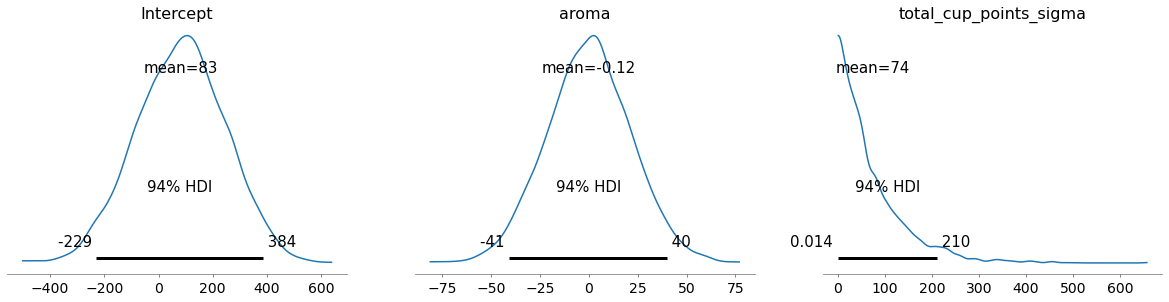

In [18]:

model2.plot_priors()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, aroma, total_cup_points_sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 34 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,34.334,1.751,31.107,37.672,0.010,0.007,30410.0,16688.0,1.0
aroma,6.310,0.231,5.873,6.738,0.001,0.001,30394.0,16800.0,1.0
total_cup_points_sigma,1.723,0.051,1.626,1.818,0.000,0.000,26481.0,15941.0,1.0


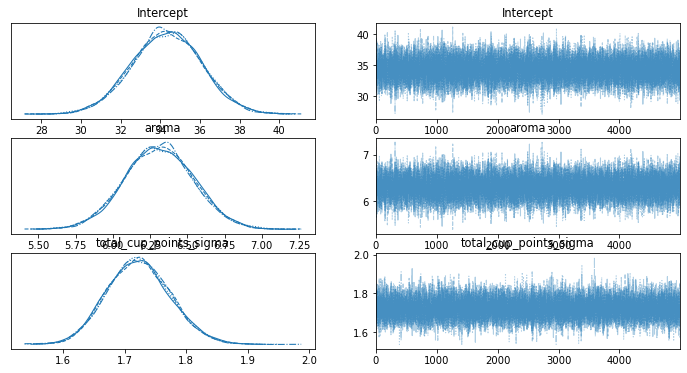

In [9]:
results2 = model2.fit(draws=5000, chains=4, cores=1)  # some bug on windows, wont work multicore.
az.plot_trace(results2)
az.summary(results2)

Changed prior to exponential on sigma and didnt change the results significantly

## Exercise 10.15 
 
Not sure if there is a better way to grab these, but this works.
UPDATE: there is a better way

In [34]:
# OLD WAY
# samples=list(zip(results2.posterior.Intercept.values.flatten(),results2.posterior.aroma.values.flatten(),results2.posterior.total_cup_points_sigma.values.flatten()))

In [10]:
samples = results2.posterior.to_dataframe().reset_index().drop(columns = ['chain','draw'])
samples.head()

,Intercept,aroma,total_cup_points_sigma
0,34.462742,6.274789,1.712560
1,33.048815,6.465968,1.673878
2,35.427899,6.167569,1.831987
3,36.406302,6.033957,1.710526
4,34.458671,6.299182,1.703877


In [11]:
first_sample = samples.iloc[0]
first_sample

Intercept                 34.462742
aroma                      6.274789
total_cup_points_sigma     1.712560
Name: 0, dtype: float64

In [12]:
def sim_data_gen(sample, aroma):
    mu = sample.aroma*aroma+ sample.Intercept
    return np.random.normal(mu,sample.total_cup_points_sigma)

In [16]:
coffee_data_sim = new_coffee.copy()
coffee_data_sim["sim_ratings"] = sim_data_gen(first_sample, coffee_data_sim["aroma"] )

<AxesSubplot:ylabel='Density'>

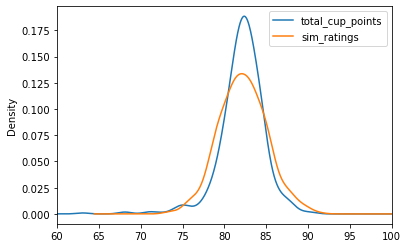

In [27]:
coffee_data_sim[["total_cup_points","sim_ratings"]].plot.kde(xlim = (60,100))

Looking at one sample , it sort of has the right character but i am suprised that my results are wider.

<AxesSubplot:xlabel='total_cup_points / total_cup_points'>

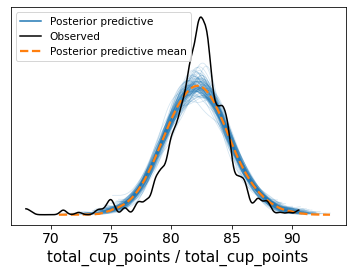

In [14]:
model2.predict(results2, kind='pps', inplace=True)
az.plot_ppc(results2, num_pp_samples=100)

This seems to confirm that my results are wider, and casts doubt on the assumption of a normal distribution.  Or I did something wrong in the modeling

In [17]:
coffee_data_sim.describe()

,total_cup_points,aroma,aftertaste,sim_ratings
count,571.000000,571.000000,571.000000,571.000000
mean,82.162820,7.579650,7.400981,82.010640
std,2.630228,0.315567,0.347670,2.639408
min,67.920000,6.500000,6.170000,74.533634
25%,80.920000,7.330000,7.170000,80.213800
50%,82.330000,7.580000,7.420000,81.867835
75%,83.625000,7.750000,7.580000,83.619857
max,90.580000,8.670000,8.670000,89.745800


Looking here, my sim_ratings has a NARROWER std, yet appears fatter. So we need some kind of fat tailed distribution, student's t might be better here

## Exercise 10.16

In [25]:
next(samples.iterrows())[1]

Intercept                 34.462742
aroma                      6.274789
total_cup_points_sigma     1.712560
Name: 0, dtype: float64

In [26]:
# For the aroma of 7.67:
posterior_predict_samples = pd.Series([sim_data_gen(sample[1], 7.67) for sample in samples.iterrows()])

<AxesSubplot:ylabel='Density'>

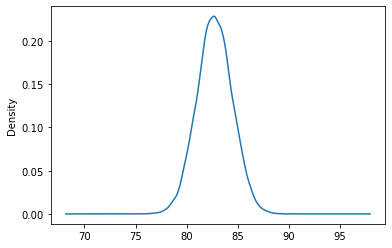

In [27]:
posterior_predict_samples.plot.kde()

In [71]:
posterior_predict_samples.describe()

count    40000.000000
mean        82.643935
std          1.977414
min         74.585552
25%         81.302362
50%         82.641891
75%         83.978684
max         90.322016
dtype: float64

In reality, this batch had a rating of 84.  A rating this high would be expected 25% of the time, so seems reasonable

In [74]:
np.mean(posterior_predict_samples >= 84)

0.24645

This is only 0.68 standard deviations away from teh mean

In [75]:
(84-np.mean(posterior_predict_samples))/np.std(posterior_predict_samples)

0.6857855099912281

/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


array([[<AxesSubplot:xlabel='total_cup_points_dim_0', ylabel='total_cup_points'>]],
      dtype=object)

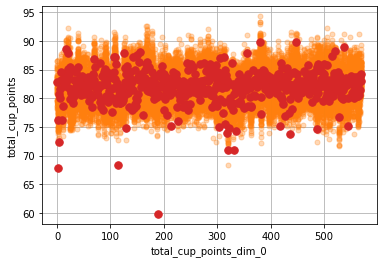

In [80]:
az.plot_lm("total_cup_points",idata=results2, legend=None)

How many batches have ratings that are within their 50% posterior prediction interval?

NOTE: rest of this uses old style, not updated

In [99]:

test =results2.posterior_predictive.total_cup_points[:,:,61].values.flatten()

In [102]:
np.quantile(test,(.25,.75))

array([78.66856667, 81.33703444])

In [108]:
# Compute 50 percent quantiles :

quantiles_50 = [np.quantile( results2.posterior_predictive.total_cup_points[:,:,i].values.flatten(), (.25,.75)) for i in range(len(new_coffee))]

In [111]:
np.mean([points >= q[0] and points <= q[1] for (points,q) in zip(new_coffee["total_cup_points"],quantiles_50) ])

0.6847635726795096

## Exercise 10.17

Look at the az.loo ? 

In [14]:
az.loo(results2)

/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 40000 posterior samples and 571 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1213.38    71.46
p_loo       17.00        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      570   99.8%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1    0.2%

I think to get the cross validated MAE we will need to do teh k-fold cross validation by hand. 

In [32]:
def MeasureMAE(train_data, test_data):
    sigma_prior = bmb.Prior('Exponential', lam= 1/75.)
    model =  bmb.Model('total_cup_points ~ aroma', train_data, priors = {'sigma': sigma_prior})
    results = model.fit(draws=10000, chains=4)
    model.predict(results,data = test_data, inplace=True)
    return np.median([np.abs(test_data.iloc[i]["total_cup_points"]-np.mean(results.posterior.total_cup_points_mean[:,:,i].values.flatten())) 
           for i in range(len(test_data))])

    

In [33]:
MeasureMAE(new_coffee,new_coffee)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, aroma, total_cup_points_sigma]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.


Now to try 10 fold CV

In [43]:
fold_labels = np.repeat([1,2,3,4,5,6,7,8,9,10],58)
np.random.shuffle(fold_labels)
fold_labels = fold_labels[:len(new_coffee)]
new_coffee["fold"] = fold_labels

In [ ]:
mae_cv = [MeasureMAE(new_coffee[new_coffee["fold"] != i], new_coffee[new_coffee["fold"] == i]) for i in range(1,11)]

Note: Lots of diagnostic output deleted.

 Ok so now mae_cv has the Median absolute prediction error for each of the folds. They are generally quite small! 

In [49]:
np.mean(mae_cv)

0.8279155257300225

# Additional Topics

Note that I can make a better LM plot if I add in the x data from somewhere else. This seems to be a bug with Bambi fitting in that it doesnt include the `constant_data` data. No idea why

/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


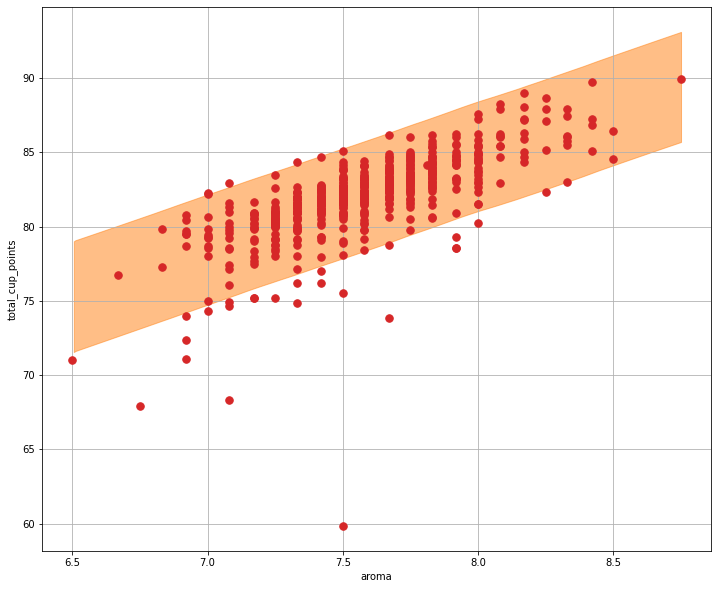

In [125]:
az.plot_lm(y="total_cup_points", idata=results2, x=model2.data.aroma, figsize= (12,10),kind_pp = 'hdi', legend= None);

In [127]:
az.plot_lm(y="total_cup_points", idata=results2, x="aroma", figsize= (12,10),kind_pp = 'hdi', legend= None);

AttributeError: 'InferenceData' object has no attribute 'constant_data'

In [129]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.1.4


In [140]:
with pm.Model() as model:
    # define priors
    a = pm.Normal('beta', 0, 22)
    b = pm.Normal('intercept', 82, 166)
    s = pm.Exponential('sigma', 1)
    
    aroma = pm.Data('aroma', new_coffee['aroma'],mutable = False)
    # predictions
    obs = pm.Normal('observation', a*aroma + b, s, observed=new_coffee['total_cup_points'])
    
    # use MCMC to sample
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept, sigma]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


In [141]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [146]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


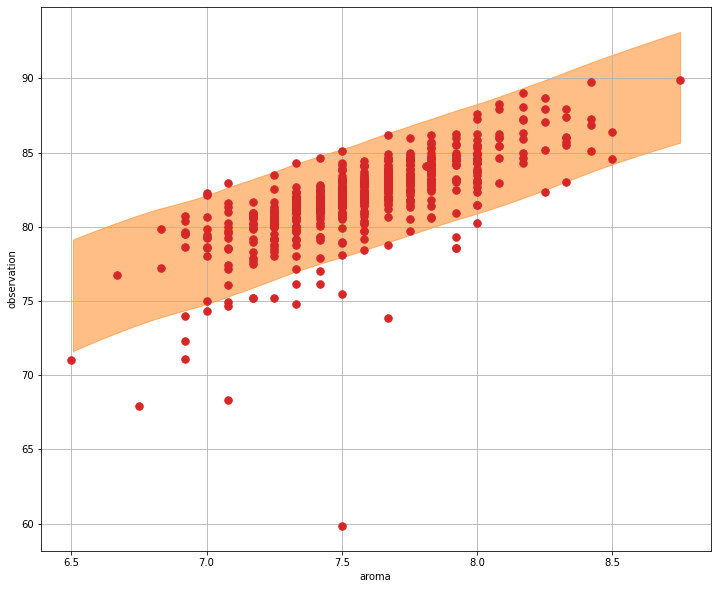

In [147]:
az.plot_lm(y="observation", idata=trace, x='aroma' , figsize= (12,10),kind_pp = 'hdi', legend= None);